# Application of regression discontinuity: banking recovery ${^1}$
<p> Regression discontinuity searches for jumps in the output regression function such that at such points the regression function, which is usually at least C<sup>0</sup> continuous, loses its property of continuity at these jump regions. This methodology can be used to model processes that exhibit certain jumps caused due to a change in the underlying mechanism where location of the jump may be of interest. One such process is debt recovery in banks where the recovery amount depends on recovery strategies. In general, more expensive recovery strategies can lead to higher proportion of recovered funds. Profitability of these decisions hinges on optimizing appropriate recovery strategies to acheive a balance of recovery expenses incurred and recovered funds. Regression discontinuity can be applied to such problems in order to determine the effect of the recovery strategy and the profitability of it. </p>
<p>In this example, the bank has implemented different recovery strategies at different thresholds (\$0, \$1000, \$2000, \$3000 and \$5000) where the greater the Expected Recovery Amount, the more effort the bank puts into contacting the customer. </p>
<p><img src="images/disgraph.png",width="800",height="800"></p>
<p>In the below cells we'll perform EDA on the example dataset, then perform a rudimentary analysis, and finally reach certain conclusions based on the results.</p>
<sub>[1] Howard Friedman, "Which Debts Are Worth the Bank's Effort?", Datacamp </sub>

In [232]:
# Import modules
import pandas as pd
import numpy as np

# Read in dataset
df = pd.read_csv('../data/bank_data.csv')


#Converting viable columns into category variables
def convert_cat_cols(df,cat_var_limit=100,verbose=True):
    temp_var = df.apply(lambda x: len(x.value_counts()))
    temp_var = temp_var[temp_var<len(df)/cat_var_limit].index
    df[temp_var] = df[temp_var].astype('category')
    if verbose:
        print(df[temp_var].describe())
    return df

df = convert_cat_cols(df,verbose=False)

print(df.info())
print(df.describe())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
id                          1882 non-null int64
expected_recovery_amount    1882 non-null int64
actual_recovery_amount      1882 non-null float64
recovery_strategy           1882 non-null category
age                         1882 non-null int64
sex                         1882 non-null category
dtypes: category(2), float64(1), int64(3)
memory usage: 62.9 KB
None
                id  expected_recovery_amount  actual_recovery_amount  \
count  1882.000000               1882.000000             1882.000000   
mean   1035.596174               2759.967588             4000.967837   
std     591.458429               2019.826565             4576.506350   
min       6.000000                194.000000              200.425000   
25%     534.250000               1261.250000             1045.190300   
50%    1029.500000               2062.000000             2115.446373   
75%    1551.750000       

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


## 2. EDA

<p>A key question is whether there are other factors besides Expected Recovery Amount that also varied systematically across the thresholds. For example, does the customer age show a jump (discontinuity) at the thresholds. We want to convince ourselves that variables such as age and sex are similar above and below the Expected Recovery Amount threshold. This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.</p>


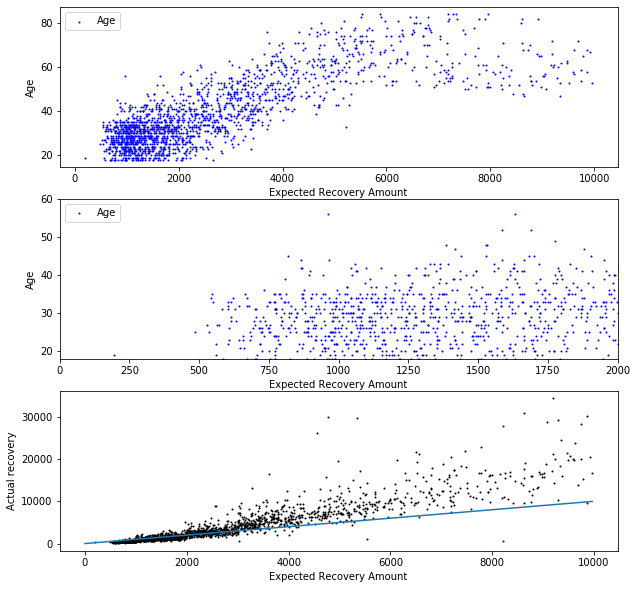

In [233]:
# Scatter plot of Age vs. Expected Recovery Amount
import matplotlib.pyplot as plt 
%matplotlib inline
plt.subplots(figsize=(10, 10))
plt.subplot(3,1,1)
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="b", s=1,label='Age')
plt.xlabel('Expected Recovery Amount'); plt.ylabel('Age')
plt.legend(loc=2)

plt.subplot(3,1,2)
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="b", s=1,label='Age')
plt.xlim(0,2000); plt.ylim(df['age'].min(),60)
plt.xlabel('Expected Recovery Amount'); plt.ylabel('Age')
plt.legend(loc=2)

plt.subplot(3,1,3)
plt.scatter(x=df['expected_recovery_amount'], y=df['actual_recovery_amount'], c="k", s=1)
plt.xlabel('Expected Recovery Amount'); plt.ylabel('Actual recovery')
plt.plot([0,df['expected_recovery_amount'].max()],[0,df['expected_recovery_amount'].max()])
plt.show()

<p>The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around \$1000.  We will now do statistical analysis examining the average age of the customers just above and just below the threshold. We can start by exploring the range from \$900 to \$1100.</p>
<p>For determining if there is a difference in the ages just above and just below the threshold, we will use the Kruskal-Wallis test, a statistical test that makes no distributional assumptions.</p>

In [234]:
df = df.set_index(['recovery_strategy','id']).sort_index()
rec_labels= df.index.get_level_values(0).categories


Level 0 Recovery mean
        expected_recovery_amount  actual_recovery_amount        age
sex                                                                
Female                981.600000              679.272667  25.666667
Male                  981.761905              576.763333  26.761905

Level 1 Recovery mean
        expected_recovery_amount  actual_recovery_amount        age
sex                                                                
Female               1028.555556              863.690985  27.388889
Male                 1027.944444              977.989867  30.055556

Chi square P-value of sex groups: 0.6361775669247722

Level 1 Recovery mean
        expected_recovery_amount  actual_recovery_amount        age
sex                                                                
Female               1956.210526             1732.320107  29.684211
Male                 1961.058824             2061.637006  31.588235

Level 2 Recovery mean
        expected_recovery_amount  actu

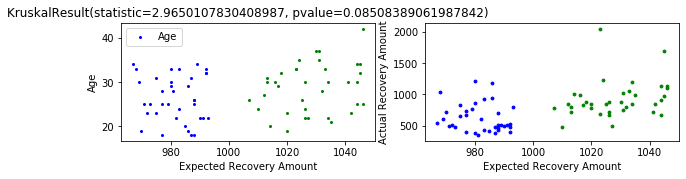

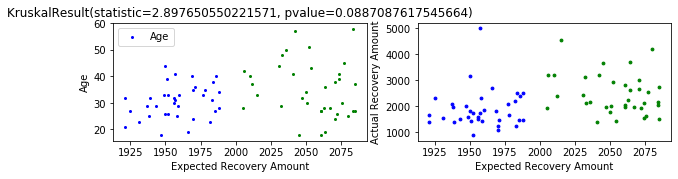

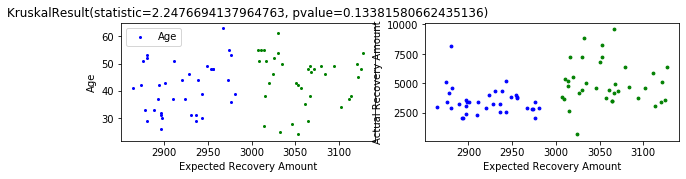

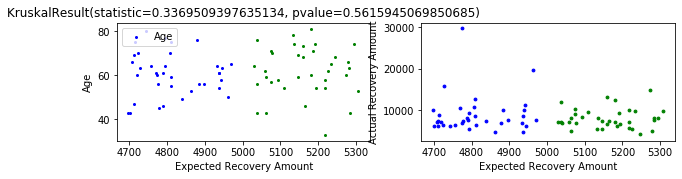

In [236]:
# Import stats module
from scipy import stats

diff_up = 4
diff_down = 40
ctr=1
for i in range(len(rec_labels)-1):
    temp_low_var = df.loc[rec_labels[i]].sort_values('expected_recovery_amount', ascending=False)
    age_low = temp_low_var['age'][diff_up:diff_down].values

    temp_high_var = df.loc[rec_labels[i+1]].sort_values('expected_recovery_amount', ascending=True)
    age_high = temp_high_var['age'][diff_up:diff_down].values
    #----------------------------------------------
    # Plotting
    #----------------------------------------------
    plt.subplots(figsize=(10, 10))
    plt.subplot(len(rec_labels)-1,2,ctr)
    plt.scatter(x=temp_low_var['expected_recovery_amount'][diff_up:diff_down], y=age_low, c="b", s=4,label='Age')
    plt.scatter(x=temp_high_var['expected_recovery_amount'][diff_up:diff_down], y=age_high, c="g", s=4)
    plt.xlabel('Expected Recovery Amount'); plt.ylabel('Age')
    plt.legend(loc=2)
    plt.title(stats.kruskal(age_low,age_high))
    ctr += 1
    plt.subplot(len(rec_labels)-1,2,ctr)
    plt.scatter(x=temp_low_var['expected_recovery_amount'][diff_up:diff_down],\
                y=temp_low_var['actual_recovery_amount'][diff_up:diff_down], c="b", s=8)
    plt.scatter(x=temp_high_var['expected_recovery_amount'][diff_up:diff_down],\
                y=temp_high_var['actual_recovery_amount'][diff_up:diff_down], c="g", s=8)
    plt.xlabel('Expected Recovery Amount'); plt.ylabel('Actual Recovery Amount')
    ctr += 1
    #----------------------------------------------
    # End Plotting
    #----------------------------------------------
    
    print('\n'+rec_labels[i]+' mean')
    temp_tab_var_low = temp_low_var[diff_up:diff_down].groupby('sex')
    print(temp_tab_var_low.mean())
    print('\n'+rec_labels[i+1]+' mean')
    temp_tab_var_high = temp_high_var[diff_up:diff_down].groupby('sex')
    print(temp_tab_var_high.mean())
    
    crosstab = pd.concat([temp_tab_var_low.count()['age'],temp_tab_var_high.count()['age']],axis='columns')
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
    print('\nChi square P-value of sex groups: '+ str(p_val))



KruskalResult(statistic=0.9999999999999963, pvalue=0.3173105078629121)